# Lab session 6

In and after this lab session you will

    - train a Gaussian NBC with the EM algorithm
    - compare the results you get to those of the k-Means clustering provided in SciKitLearn
    - discuss the classifiers from this lab session and those from the previous session (supervised learning of NBCs) in a 
    brief report
    

### Import MNIST dataset from sklearn

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn import metrics

In [2]:
mnist = load_digits()
print("Imported ", len(mnist.data), " number of images from MNIST dataset")
x_train, x_test, y_train, y_test = train_test_split(mnist.data, mnist.target,test_size = 0.3)

print("Split into a 70/30 ratio between train and test set")
print("Number of training data ", x_train.shape)
print("Number of test data ", x_test.shape)

Imported  1797  number of images from MNIST dataset
Split into a 70/30 ratio between train and test set
Number of training data  (1257, 64)
Number of test data  (540, 64)


### Create the EM-algorithm

In [9]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
from numpy import linalg as npl

In [17]:
### THIS IS NOT NAIVE!

class EM_alg():
    def __init__(self, n_clusters, epsilon = 1e-7):
        self.n_clusters = n_clusters
        self.mu = {}
        self.std = {}
        self.p_C = {}
        self.eps = epsilon
        self.n_features = 0
        self.r = {}
        self.N = 0

    
    def log_prob(self, x, label):
        prob = np.sum(-1/2*np.log(npl.det(self.std[label])+self.eps) - \
                1/2*np.inner(x-self.mu[label],np.matmul(npl.pinv(self.std[label] + np.eye(self.n_features)*self.eps),x-self.mu[label])))
        return prob
        
        
    
    def E_step(self, X):
        for point in range(self.N):
       # for label in range(self.n_clusters):
            self.r[label] = np.zeros(self.N)
            nominator = np.sum([np.log(self.p_C[k] + self.eps)+self.log_prob(X[point,:],k) for k in range(self.n_clusters)])
            # for point in range(self.N):
            for label in range(self.n_clusters):
                nominator = np.sum([self.p_C[k]*+np.exp(elf.log_prob(X[point,:],k)) for k in range(self.n_clusters)])
                self.r[label][point] = self.p_C[label]*np.exp(self.log_prob(X[point,:],label))/nominator
            
        
    def M_step(self, X):
        for label in range(self.n_clusters):
            r_k = np.sum([self.r[label][i] for i in range(self.N)])
            self.p_C[label] = r_k/self.N
            self.mu[label] = np.sum([self.r[label][i]*X[i] for i in range(self.N)],axis = 0)/r_k
            top = np.zeros((self.n_features,self.n_features))
            for i in range(self.N):
                top += self.r[label][i]*X[i,:]*np.transpose(X[i,:])
            self.std[label] = top/r_k - np.outer(self.mu[label],self.mu[label])
        

    def fit(self, X):    
        self.n_features = X.shape[1]
        self.N = X.shape[0]
        for label in range(self.n_clusters):
            self.mu[label] = np.random.rand(self.n_features)*np.max(X)
            self.std[label] = np.diag(np.random.rand(self.n_features))
            
            self.p_C[label]= 1/self.n_clusters
            
        for i in range(10):
            self.E_step(X)
            self.M_step(X)
                    
            
    def predict(self, X_new):
        yhat = np.zeros(X_new.shape[0])
        for point in range(X_new.shape[0]):
            yhat[point] = np.argmax([np.log(self.p_C[k] + self.eps)+self.log_prob(X_new[point,:],k) for k in range(self.n_clusters)])

        return yhat
            
        

In [18]:
em = EM_alg(10)
em.fit(x_train)

In [27]:
em.mu
predictions = em.predict(x_train)

In [28]:
print("Confusion matrix own GNB:\n%s" % metrics.confusion_matrix(y_train, predictions))

Confusion matrix own GNB:
[[  0   6   0  35   0  83   0   0  11   1]
 [  8   3  67   8   2  10   2   0  28   0]
 [  0   3   0  46   2   2  60   3  13   2]
 [  0   7   0 117   1   0   0   0   0   2]
 [  0   1  26   0   0  90   0   0   1   2]
 [  1  14  46  44   2   9   0   1   1   1]
 [  0   0   1   0   1  75   0   0  50   0]
 [  1   0  49  23   0   3  18   1   8  32]
 [  1   6  25  28   7  19   5   0  10  12]
 [  0   3   0  98   1   1   2   0  11   5]]


In [21]:
class own_KMeans():
    def __init__(self, n_clusters, epsilon = 1e-5):
        self.n_clusters = n_clusters
        self.eps = epsilon
        self.p_C = {}
        self.mu = {}
    
    def E_step(self, X):
        for i,x in enumerate(X):
            self.y[i] = np.argmin([npl.norm(x-self.mu[label]) for label in range(self.n_clusters)])
       
    def M_step(self, X):
        for label in range(self.n_clusters):
            Ci = self.y == label
            if sum(np.array(Ci)) != 0:
                self.mu[label] = np.sum(X[Ci,:], axis = 0)/sum(np.array(Ci))
      

    def fit(self, X):
        self.y = np.zeros(X.shape[0]) 
        for label in range(self.n_clusters):
            self.p_C[label] = 1/self.n_clusters
            self.mu[label] = np.random.rand(X.shape[1])*np.max(X)
        
        for i in range(10):
            self.E_step(X)
            self.M_step(X)
            
    def get_labels(self):
        return self.y
            
    def predict(self,X_new):
        yhat = np.zeros(X_new.shape[0])
        for i,x in enumerate(X_new):
            yhat[i] = np.argmin([npl.norm(x-self.mu[label]) for label in range(self.n_clusters)])
        
        return yhat
        
        

In [22]:
own_kmeans = own_KMeans(10)
own_kmeans.fit(x_train)

In [25]:
# own_kmeans.mu
predictions = own_kmeans.predict(x_train)

In [24]:
y_train

array([8, 4, 6, ..., 8, 0, 4])

In [26]:
print("Confusion matrix own GNB:\n%s" % metrics.confusion_matrix(y_train, predictions))

Confusion matrix own GNB:
[[ 69   0   0   0   0   0  66   0   0   1]
 [  0   0   2  35   1  20   0   0  70   0]
 [  0   0   0   0   7 109   0  10   5   0]
 [  0   0   0   1   4   0   0 115   7   0]
 [  0   0   0   0   5   0   0   0   2 113]
 [  0   0   0  19   0   0   0  43  56   1]
 [  0   0 126   0   0   0   0   0   1   0]
 [  0   0   0   4 125   0   0   0   6   0]
 [  0   0   1  14   2   2   0  29  65   0]
 [  0   0   0  19   3   0   0  97   2   0]]


### SKLearn K-means

In [142]:
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

In [7]:
kmeans = KMeans(n_clusters=10).fit(x_train)

In [108]:
print("Labels from the kmeans algorithm: ", kmeans.labels_)
print("Lables in y_train: ", y_train)
# print("Cluster centers for the kmeans alg: ", kmeans.cluster_centers_)

Labels from the kmeans algorithm:  [9 3 6 ... 1 5 6]
Lables in y_train:  [9 8 5 ... 1 0 9]
Cluster centers for the kmeans alg:  [[ 0.00000000e+00  5.52000000e-01  8.15200000e+00  1.42800000e+01
   1.41440000e+01  7.17600000e+00  3.84000000e-01 -2.35922393e-16
   1.60000000e-02  4.17600000e+00  1.27520000e+01  9.09600000e+00
   1.10000000e+01  1.21840000e+01  1.66400000e+00 -1.38777878e-17
   8.00000000e-03  2.32800000e+00  4.26400000e+00  3.56800000e+00
   1.16320000e+01  9.68800000e+00  7.76000000e-01  9.02056208e-17
  -1.62630326e-18  2.00000000e-01  9.84000000e-01  7.88000000e+00
   1.38880000e+01  6.31200000e+00  2.64000000e-01 -3.25260652e-18
   0.00000000e+00  8.80000000e-02  5.20000000e-01  4.00800000e+00
   1.15440000e+01  1.19280000e+01  2.33600000e+00  0.00000000e+00
  -1.90819582e-17  4.96000000e-01  1.41600000e+00  4.80000000e-01
   4.02400000e+00  1.20400000e+01  6.58400000e+00  5.20417043e-17
  -2.60208521e-17  8.16000000e-01  7.01600000e+00  6.49600000e+00
   8.12000000e

In [156]:
BGMM = BayesianGaussianMixture(n_components = 10)
predictions = BGMM.fit_predict(x_train)

In [159]:
print(kmeans.labels_)
print(predictions)
print(y_train)

[9 3 6 ... 1 5 6]
[6 9 0 ... 7 5 0]
[9 8 5 ... 1 0 9]


In [162]:
print("Confusion matrix sklearn NBGMM:\n%s" % metrics.confusion_matrix(y_train, predictions))

Confusion matrix own GNB:
[[  0   0   0   0   0 129   0   0   0   0]
 [  0   1  39   0   0   0   0  16   0  68]
 [  0   0   2   0   8   1   0 105   0   4]
 [  3   0   0   1 113   0   4   0   0   9]
 [  0   0   5   0   0   0   6   0 116   2]
 [ 37   1   0  89   0   0   0   0   1   0]
 [  0 120   1   0   0   0   0   0   0   2]
 [  0   0   2   1   0   0 128   0   0   0]
 [ 36   2   6   5   2   0   3   1   0  72]
 [ 95   0  10   2   2   0   7   0   0   0]]


3

# EM Algorithm according to Lab description

In [10]:
import time
import numpy as np
from numpy import linalg as npl

In [11]:
class my_NaiveEM_alg():
    def __init__(self, n_clusters, epsilon = 1e-3, tol = 1e-3):
        self.n_clusters = n_clusters
        self.mu = {}
        self.std = {}
        self.p_C = {}
        self.eps = epsilon
        self.n_features = 0
        self.r = {}
        self.N = 0
        self.mu_old = {}
        self.tol = tol

    
    def log_prob(self, x, label):
        prob = np.sum([-1/2*np.log(2*np.pi*self.std[label][j] + self.eps) - (x[j] - self.mu[label][j])**2/(2*self.std[label][j] + self.eps) for j in range(len(x))])
        return prob
    
    def prob(self, x, label):
        prob = sum([-1/2*np.log(2*np.pi*self.std[label][j] + self.eps) - (x[j] - self.mu[label][j])**2/(2*self.std[label][j] + self.eps) for j in range(len(x))])
        return np.exp(prob)
        
        
    
    def E_step(self, X):
        for point in range(self.N):
            nominator = sum([self.p_C[k]*self.prob(X[point,:],k) for k in range(self.n_clusters)])
            for label in range(self.n_clusters):
                self.r[label][point] = (self.p_C[label])*self.prob(X[point,:],label)/nominator
        
    def M_step(self, X):
        for label in range(self.n_clusters):
            r_k = sum(self.r[label])
            top = np.zeros(self.n_features)
            for i in range(self.N):
                top += self.r[label][i]*np.diag(np.outer(X[i,:],X[i,:]))
            self.p_C[label] = r_k/self.N
            self.mu_old[label] = self.mu[label]
            self.mu[label] = np.sum([self.r[label][i]*X[i,:] for i in range(self.N)],axis = 0)/r_k
            self.std[label] = top/r_k - np.diag(np.outer(self.mu[label],self.mu[label]))
        

    def fit(self, X):    
        self.n_features = X.shape[1]
        self.N = X.shape[0]
#         indexes = np.random.choice(self.N, 10)
        indexes = [i for i in range(self.N)]
        batch = int(self.N/self.n_clusters)
        np.random.shuffle(indexes)
        for label in range(self.n_clusters):
            self.r[label] = np.zeros(self.N)
            idx = indexes[label*batch:(label+1)*batch]
            self.mu_old[label] = np.zeros(self.n_features)
            self.mu[label] = np.mean(X[idx,:], axis = 0)
            self.std[label] = np.var(X[idx,:], axis = 0)
            self.p_C[label]= 1/self.n_clusters
            
        for i in range(100):
            print("On step : ", i)
            e_time_s = time.monotonic()
            self.E_step(X)
            print("Time to do one E-step: ", time.monotonic()-e_time_s)
            m_time_s = time.monotonic()
            self.M_step(X)
            print("Time to do one M-step: ", time.monotonic()-m_time_s)
            change = 0
            for label in range(self.n_clusters):
                change += npl.norm(self.mu[label] - self.mu_old[label])
            print(change)
            if change < self.tol:
                print("Reached the tolerance and therefore converged!")
                break
            print("Prior : ", self.p_C)
    
    def fit_cont(self,X,nbr_iters=10):
        for i in range(nbr_iters):
            print("On step : ", i)
            e_time_s = time.monotonic()
            self.E_step(X)
            print("Time to do one E-step: ", time.monotonic()-e_time_s)
            m_time_s = time.monotonic()
            self.M_step(X)
            print("Time to do one M-step: ", time.monotonic()-m_time_s)
            print("Prior : ", self.p_C)
    
        
                    
            
    def predict(self, X_new):
        yhat = np.zeros(X_new.shape[0])
        for point in range(X_new.shape[0]):
            yhat[point] = np.argmax([np.log(self.p_C[k] + self.eps)+self.log_prob(X_new[point,:],k) for k in range(self.n_clusters)])
        return yhat


In [12]:
x_train_n = x_train/16.0
# M = np.mean(x_train,axis = 0)
# STD = np.std(x_train,axis = 0)
# x_train_n = np.zeros(x_train.shape)
# for i in range(x_train.shape[1]):
#     if STD[i] != 0:
#         x_train_n[:,i] = (x_train[:,i]-M[i])/STD[i]
#     else:
#         x_train_n[:,i] = x_train[:,i]-M[i]
# np.std(x_train_n,axis = 0)

In [13]:
nem = my_NaiveEM_alg(10)
nem.fit(x_train_n)

On step :  0
Time to do one E-step:  33.60899999999674
Time to do one M-step:  1.422000000020489
9.8384239478358
Prior :  {0: 0.01762973428693039, 1: 0.10678200333927156, 2: 0.029462124228553477, 3: 0.014423833929257923, 4: 0.597397256103865, 5: 0.0029413022811440714, 6: 0.01590795500557732, 7: 0.08730390491591182, 8: 0.103698105817284, 9: 0.024453780092205047}
On step :  1
Time to do one E-step:  35.79599999997299
Time to do one M-step:  1.8440000000409782
5.0896597664235355
Prior :  {0: 0.012446713206311844, 1: 0.11185081497760846, 2: 0.04689887860632497, 3: 0.04694148871706949, 4: 0.4625277360615247, 5: 0.0033491383840795453, 6: 0.055980264103271594, 7: 0.12463558180592049, 8: 0.10454176943103824, 9: 0.030827614706850623}
On step :  2
Time to do one E-step:  44.59399999998277
Time to do one M-step:  2.0619999999762513
2.817368093962427
Prior :  {0: 0.04105138135203715, 1: 0.12785341197796957, 2: 0.06487974438627936, 3: 0.04333019354064921, 4: 0.36550571486897554, 5: 0.00508048380965

Time to do one E-step:  38.46900000004098
Time to do one M-step:  1.452999999979511
0.3483143774769249
Prior :  {0: 0.09886980903395286, 1: 0.09101750440422002, 2: 0.11732633318498335, 3: 0.037365931283068754, 4: 0.19085355617017738, 5: 0.06048646310813883, 6: 0.07128994430560144, 7: 0.17279074280053927, 8: 0.10547339598867723, 9: 0.054526319720640946}
On step :  24
Time to do one E-step:  36.92200000002049
Time to do one M-step:  1.9219999999622814
0.2744825247221391
Prior :  {0: 0.09887992688681316, 1: 0.09348397333768531, 2: 0.11616579658558018, 3: 0.037294788366381414, 4: 0.1878174993808831, 5: 0.060564200685981014, 6: 0.0749291100521158, 7: 0.16870673577276624, 8: 0.1066410859377921, 9: 0.055516882994001475}
On step :  25
Time to do one E-step:  42.73499999998603
Time to do one M-step:  2.25
0.2528750221380366
Prior :  {0: 0.09769171464339342, 1: 0.09669890997430992, 2: 0.11510308166610939, 3: 0.03725066803313112, 4: 0.1860587864237275, 5: 0.06061768397880166, 6: 0.075345846060197

Time to do one E-step:  40.56300000002375
Time to do one M-step:  1.702999999979511
0.13423382193257374
Prior :  {0: 0.09372434595041038, 1: 0.10985467233270488, 2: 0.10086869250658846, 3: 0.0371502561205168, 4: 0.1045103162829536, 5: 0.06070705702190461, 6: 0.07760535353931096, 7: 0.24289703096475307, 8: 0.11380752695907348, 9: 0.05887474832178385}
On step :  47
Time to do one E-step:  39.21799999999348
Time to do one M-step:  1.625
0.1373492654658694
Prior :  {0: 0.09326468895703663, 1: 0.11007259288917576, 2: 0.1006780219985629, 3: 0.037150384160677466, 4: 0.10176414992987963, 5: 0.06070705376054371, 6: 0.07793941761971884, 7: 0.24487628722474533, 8: 0.11388746200692826, 9: 0.059659941452731326}
On step :  48
Time to do one E-step:  43.01600000000326
Time to do one M-step:  1.6709999999729916
0.052545184673952645
Prior :  {0: 0.0930825497376244, 1: 0.11018557587296081, 2: 0.10020921796361125, 3: 0.03715048574677818, 4: 0.10101116044897523, 5: 0.06070638810344237, 6: 0.07797526928769

Time to do one E-step:  37.375
Time to do one M-step:  1.5309999999590218
0.0017871740686564112
Prior :  {0: 0.0921447206457053, 1: 0.11132655079686843, 2: 0.09387502756335421, 3: 0.037150407019440564, 4: 0.10023866347416101, 5: 0.060706465901831985, 6: 0.08041284980031649, 7: 0.24717239571592622, 8: 0.11735113018511327, 9: 0.05962178889728261}
On step :  70
Time to do one E-step:  45.79700000002049
Time to do one M-step:  1.0310000000172295
0.0022978589769845916
Prior :  {0: 0.09209825678795079, 1: 0.1113741623841655, 2: 0.09387503855997233, 3: 0.03715040653844939, 4: 0.10023866347413261, 5: 0.060706465996637246, 6: 0.08041131188471488, 7: 0.2471719090458485, 8: 0.1173522619290409, 9: 0.0596215233990876}
On step :  71
Time to do one E-step:  40.65599999995902
Time to do one M-step:  1.422000000020489
0.00407443985844723
Prior :  {0: 0.09201402848116404, 1: 0.11145844573025526, 2: 0.09387503578650201, 3: 0.037150406069445814, 4: 0.10023866347409621, 5: 0.060706466011095236, 6: 0.080410

In [14]:
x_test_n = x_test/16.0
preds = nem.predict(x_test_n)

In [16]:
print("Confusion matrix own NBGMM:\n%s" % metrics.confusion_matrix(y_test, preds))

Confusion matrix own NBGMM:
[[ 0  0  0  0 48  2  0  1  0  0]
 [ 0  4  0  0  0  0 25  0 13 21]
 [ 0  0  0  0  0  0  0  4 45  0]
 [ 0  5  0  0  0  0  0 42  4  0]
 [ 3  1  0 20  0 20  0  0  0  7]
 [ 0 34  0  0  0  0  0 20  0  1]
 [ 0  0 56  0  0  0  0  1  0  0]
 [47  1  0  0  0  0  0  1  0  4]
 [ 1  8  0  0  0  0 15 21  1  2]
 [ 7  2  0  0  0  0  0 44  2  7]]


## Confusion matrix looks bad so lets do some plotting and change the labels

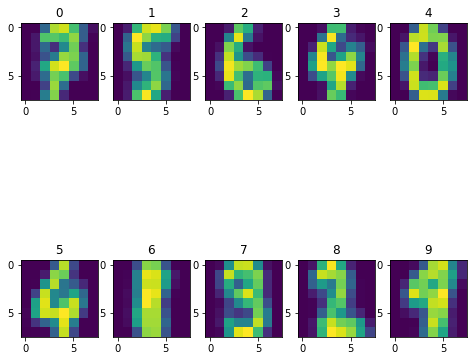

In [30]:
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(nem.mu[i],(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i)
plt.show()
# for i in range(10):
#     img = np.reshape(nem.mu[i],(8,8))
#     imgplot = plt.imshow(img)
#     plt.show()

In [47]:
preds_fix = np.zeros(len(preds))
preds_fix[preds == 0] = 7
preds_fix[preds == 1] = 5
preds_fix[preds == 2] = 6
preds_fix[preds == 3] = 8
preds_fix[preds == 4] = 0
preds_fix[preds == 5] = 4
preds_fix[preds == 6] = 1
preds_fix[preds == 7] = 3
preds_fix[preds == 8] = 2
preds_fix[preds == 9] = 9

In [49]:
print("Confusion matrix own NBGMM:\n%s" % metrics.confusion_matrix(y_test, preds_fix))

Confusion matrix own NBGMM:
[[48  0  0  1  2  0  0  0  0  0]
 [ 0 25 13  0  0  4  0  0  0 21]
 [ 0  0 45  4  0  0  0  0  0  0]
 [ 0  0  4 42  0  5  0  0  0  0]
 [ 0  0  0  0 20  1  0  3 20  7]
 [ 0  0  0 20  0 34  0  0  0  1]
 [ 0  0  0  1  0  0 56  0  0  0]
 [ 0  0  0  1  0  1  0 47  0  4]
 [ 0 15  1 21  0  8  0  1  0  2]
 [ 0  0  2 44  0  2  0  7  0  7]]


In [343]:
print(nem.p_C)
label_dist = [sum(y_train==i)/len(y_train) for i in range(10)]
print(label_dist)

{0: 0.11496070169349579, 1: 0.12445934647733116, 2: 0.0918861047768727, 3: 0.0731693304046471, 4: 0.11135414659426152, 5: 0.14593368295872408, 6: 0.09626120636436795, 7: 0.03046058477710074, 8: 0.12473930962915147, 9: 0.08677558632404732}
[0.10103420843277645, 0.09944311853619729, 0.09864757358790771, 0.09069212410501193, 0.10103420843277645, 0.09864757358790771, 0.11535401750198886, 0.09785202863961814, 0.09864757358790771, 0.09864757358790771]


In [51]:
print("Classification report for othe new re-arranged labels: \n", metrics.classification_report(y_test,preds_fix))

Classification report for othe new re-arranged labels: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        51
           1       0.62      0.40      0.49        63
           2       0.69      0.92      0.79        49
           3       0.31      0.82      0.45        51
           4       0.91      0.39      0.55        51
           5       0.62      0.62      0.62        55
           6       1.00      0.98      0.99        57
           7       0.81      0.89      0.85        53
           8       0.00      0.00      0.00        48
           9       0.17      0.11      0.13        62

    accuracy                           0.60       540
   macro avg       0.61      0.61      0.58       540
weighted avg       0.61      0.60      0.58       540

